In [1]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import jax
import matplotlib.pyplot as plt

import src.sdes.sde_interest_rates as ir
from src.sdes import time, sde_utils
from src import plotting

In [2]:
t_start = 0.
T = 1.
x0 = (1.5,)
y = (1.,)
N = 1000
num_trajectories = 1000


key =  jr.PRNGKey(1)
traj_keys = jax.random.split(key, num_trajectories)

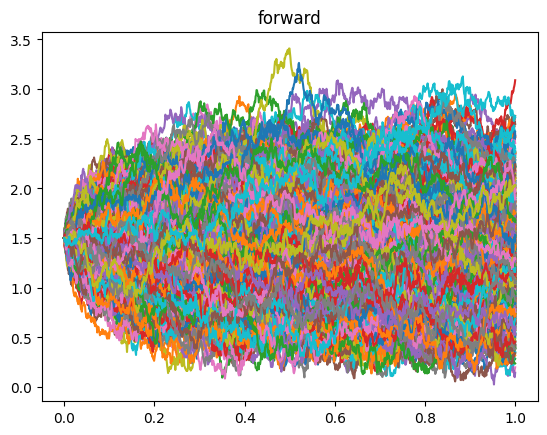

In [3]:
time_grid = time.grid(t_start=t_start, T=T ,N=N)

drift, diffusion = ir.vector_fields()
trajectories = jax.vmap(sde_utils.solution, (0, None, None, None, None))(traj_keys, time_grid, x0, drift, diffusion)

for traj in trajectories:
    plt.plot(time_grid, traj)
plt.title("forward")
plt.show()

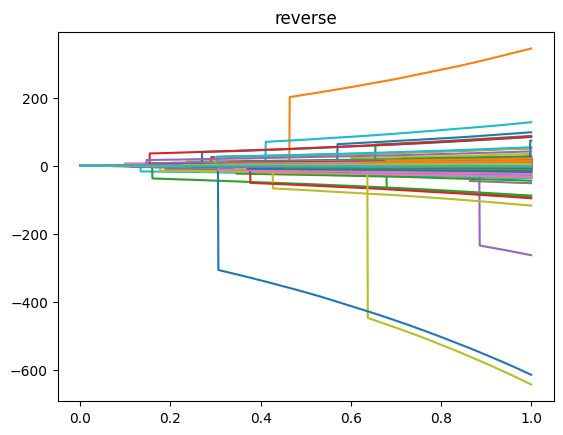

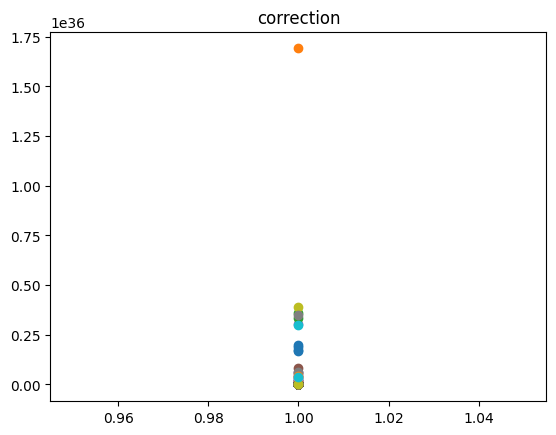

In [4]:
rev_keys = jax.random.split(key, num_trajectories)

data = ir.data_reverse(y, T, N)
ts, rev, corr = data(rev_keys)

for traj in rev:
    plt.plot(time_grid, traj)
plt.title("reverse")
plt.show()

for c in corr:
    plt.scatter(time_grid[-1], c)
plt.title("correction")
plt.show()

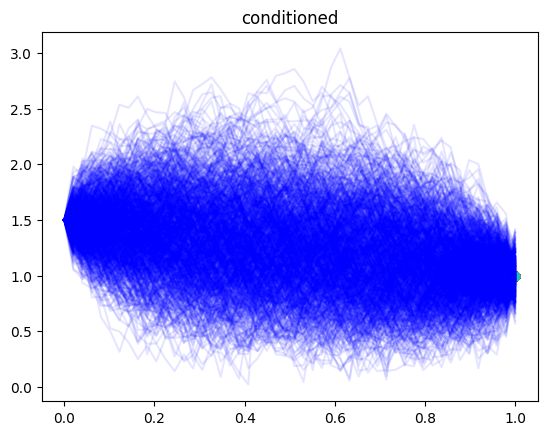

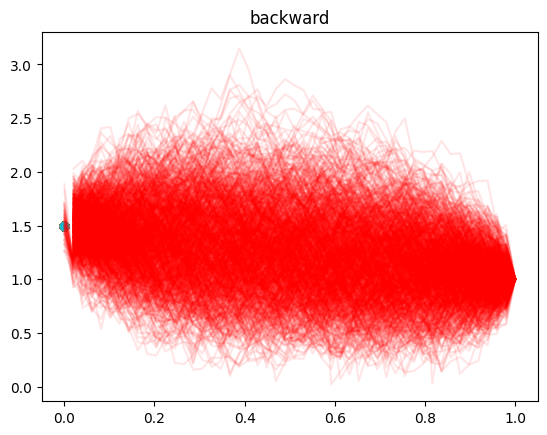

In [11]:
# Try conditioned score

score_fn = partial(ir.score, T=T, y=y)

time_grid = time.grid(t_start=t_start, T=T ,N=50)
trajectories = jax.vmap(sde_utils.conditioned, (0, None, None, None, None, None))(traj_keys, time_grid, x0, score_fn, drift, diffusion)

for traj in trajectories:
    plt.plot(time_grid, traj, alpha=0.1, color="blue")
    plt.scatter(T, jnp.asarray(y))
plt.title("conditioned")
plt.show()

score_fn_bw = partial(ir.score_forward, 0., x0)

trajectories_bw = jax.vmap(sde_utils.backward, (0, None, None, None, None, None))(traj_keys, time_grid, y, score_fn_bw, drift, diffusion)

trajectories_rev = trajectories_bw[:, ::-1]

for traj in trajectories_rev:
    plt.plot(time_grid, traj, alpha=0.1, color="red")
    plt.scatter(0., jnp.asarray(x0))
plt.title("backward")
plt.show()


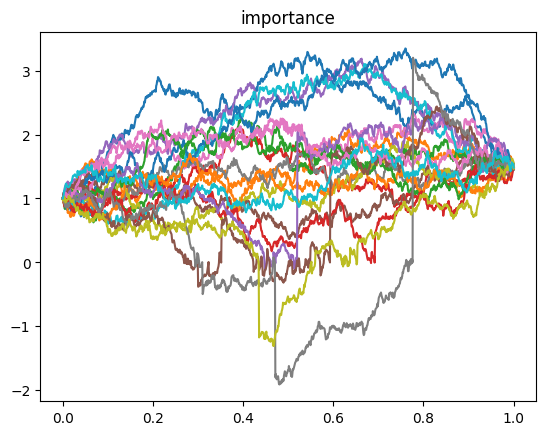

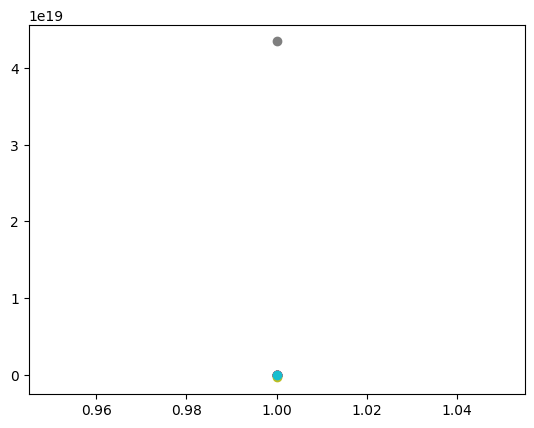

In [8]:
# importance sampled trajectories

data = ir.data_importance(x0, y, T, N)
ts, rev, corr = data(rev_keys)

for traj in rev:
    plt.plot(ts[0], traj)
plt.title("importance")
plt.show()

for c in corr:
    plt.scatter(T, c)



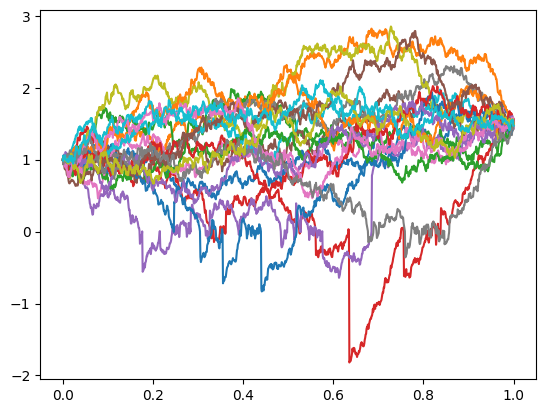

In [9]:
keys = jax.random.split(key, num_trajectories)

data_fn = ir.data_reverse_guided(x0, y, T, N)
ts, trajs, corr = data_fn(keys)

for traj in trajs:
    plt.plot(ts[0], traj)